# Predictive Modeling of Heart Disease Risk: Assessing the Role of Aerobic Fitness and Age #

## Introduction ##
#### Background information (CHANGE THIS PART): ####

Elevated levels of serum cholesterol and high blood pressure (hypertension) are well-established risk factors for the development of atherosclerosis, a condition characterized by the build-up of plaque in the arteries, these plaques can narrow the arteries, leading to a higher likelihood of developing heart disease. Furthermore, when high cholesterol levels and hypertension coexist, they can exacerbate each other's effects on blood vessel health, which causes an even greater risk of developing heart disease.
#### Our Question (CHANGE THIS PART): ####
Can we use resting blood pressure and serum cholesterol levels to predict whether a patient will develop a heart disease?
#### The Dataset: ####
We will be using the Heart Disease dataset from the UC Irvine Machine Learning Repository. The dataset includes various attributes related to heart disease diganosis. Each row in the dataset represents a patient and it contains the following variables as columns (in order): age, sex, chest pain type (4 types), resting blood pressure (mm Hg), serum cholesterol (mg/dl), fasting blood sugar, resting ECG results (3 types), max heart rate achieved, exercise induced angina (1 = present, 0 = absent), ST depression, slope of peak exercise ST segment (3 types), number of major vessels coloured by fluoroscopy (0-3), thalassemia, and presence of heart disease (0 = no, 1-4 = yes).

## Preliminary exploratory data analysis ##

In [1]:
# trestbps: resting blood pressure (mm Hg), chol: total amount of cholesterol in the body (mg/dl)
# num: presence of heart disease in a patient (presence = 1,2,3,4), (absence = 0)

library(tidyverse)
library(repr)
library(tidymodels)
# clean and wrangle data into a tidy data format
url <- "https://raw.githubusercontent.com/Isabella72/Group_project/main/processed.cleveland.data"
heart_data <- read_csv(url, col_names = FALSE) |>
        rename(age = X1, maxhr = X8, disease = X14) |>
        select(age, maxhr, disease) |>
        mutate(disease = as_factor(disease)) |>
        mutate(disease = fct_recode(disease, "Present" = "1", "Present" = "2", "Present" = "3", "Present" = "4", "Absent" = "0"))


Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
slice_head(heart_data, n = 3)

age,maxhr,disease
<dbl>,<dbl>,<fct>
63,150,Absent
67,108,Present
67,129,Present


Table 1: A preview of the first three rows of the heart disease data set

In [3]:

num_obs <- nrow(heart_data)
heart_data |>
    group_by(disease) |>
    summarize(count = n(), percentage = n()/ num_obs * 100)

disease,count,percentage
<fct>,<int>,<dbl>
Absent,164,54.12541
Present,139,45.87459


Table 1.1: The percentage of observations with no heart disease versus the percentage with heart disease

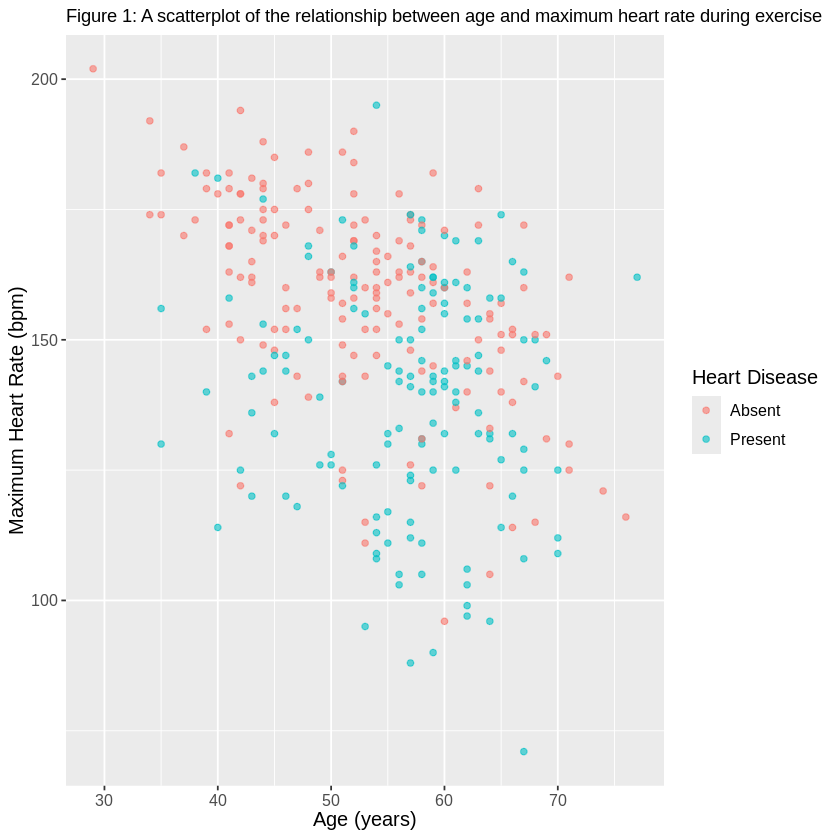

In [4]:

heart_plot <- heart_data |>
  ggplot(aes(x = age, y = maxhr, color = disease)) +
  geom_point(alpha = 0.6) +
  labs(x = "Age (years)",
       y = "Maximum Heart Rate (bpm)",
       color = "Heart Disease") +
    theme(text = element_text(size = 12)) +
    theme(plot.title = element_text(size = 11)) +
    ggtitle("Figure 1: A scatterplot of the relationship between age and maximum heart rate during exercise")
heart_plot

In [25]:
set.seed(4422)
# create the 25/75 split of the data into training and testing
heart_split <- initial_split(heart_data, prop = 0.75, strata = disease)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

# tuning the classifier
heart_vfold <- vfold_cv(heart_train, v = 10, strata = disease)
heart_recipe <- recipe(disease ~., data = heart_data) |>
        step_scale(all_predictors()) |>
        step_center(all_predictors())
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))
vfold_metrics <- workflow() |>
                  add_recipe(heart_recipe) |>
                  add_model(knn_spec) |>
                  tune_grid(resamples = heart_vfold, grid = k_vals) |>
                  collect_metrics() |>
                  filter(.metric == "accuracy") |>
                  arrange(desc(mean))
k <- vfold_metrics |>
    slice_max(n = 1, order_by = mean) |>
    select(neighbors) |>
    pull()

# evaluating performance of our model using test data
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k) |>
        set_engine("kknn") |>
        set_mode("classification")
best_fit <- workflow() |>
        add_recipe(heart_recipe) |>
        add_model(best_spec) |>
        fit(data = heart_train)
disease_predictions <- predict(best_fit, heart_test) |>
        bind_cols(heart_test)
heart_metrics <- disease_predictions |>
  metrics(truth = disease, estimate = .pred_class) |>
  filter(.metric == "accuracy")

heart_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7631579


Table 1.3: The prediction accuracy of our model on the test data

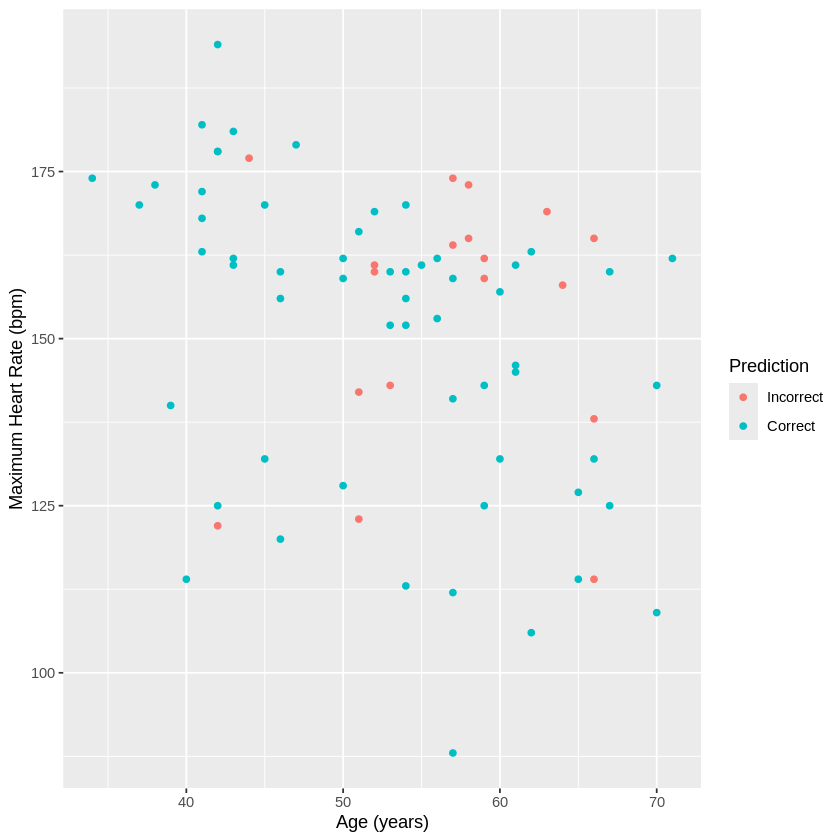

In [24]:
conf_mat <- disease_predictions |>
  conf_mat(truth = disease, estimate = .pred_class)

conf_vals <- disease_predictions |>
        mutate(conf = .pred_class == disease) |>
        mutate(conf = as_factor(conf)) |>
        mutate(conf = fct_recode(conf, "Correct" = "TRUE", "Incorrect" = "FALSE"))
conf_plot <- conf_vals |>
        ggplot(aes(x = age, y = maxhr, color = conf)) +
        geom_point() +
        labs(x = "Age (years)", y = "Maximum Heart Rate (bpm)", color = "Prediction")
conf_plot

Figure 1.1: A plot of all predictions done on test data and if prediction is correct or incorrect

## Methods ##
1. Loading and Cleaning Data:
    - Loading the Heart Disease dataset from a CSV file using read_csv.
    -  The rename function is used to assign more meaningful names to the columns
    - The select function is then used to keep only the relevant columns
2. Variable Transformation:
    - The disease column is converted to a factor 
    - Second, we recode the levels of the disease variable into more meaningful categories: "Present" for levels "1", "2", "3", and
"4", and "Absent" for level "0".

3. Data Visualization:
    - A scatter plot will be created using the ggplot2 library, visualizing the
relationship between resting blood pressure and serum cholesterol levels, colored based on the disease variable, representing the presence or absence of heart disease.
    - The scatter plot will provide a summary of the dataset,
shedding light on the distribution of heart disease cases.
This plot will enable us to observe
any potential patterns, showing how these two variables might be related to
the occurrence of heart disease.
4. Further Data Analysis:
   - To answer our question of if we can predict the occurrence of heart disease using serum cholesterol and resting blood pressure levels, we will perform k-nn classification on the data set, using the column disease as our response variable, and the columns trestbps and chol as our predictors. We'll split our data into training and testing sets, then find the k-value that provides the highest accuracy using 5-fold cross validation on our training set. Then we'll retrain our model with this k-value and evaluate the model on our test set.

## Expected outcome and significance ##
From the scatter plot, we expect to find the relationship between the two variables
"Resting Blood Pressure" and "Serum Cholesterol" for people with and without heart
disease. The graph shows that the higher the average resting blood pressure and serum
cholesterol, the more likely one is to have heart disease. Such
findings can inform people about the importance of managing these risk factors to
reduce the development of heart disease. The results of this analysis may lead to further
research into the mechanisms that link blood pressure and cholesterol levels to heart
disease and to the identification of new preventive strategies. Examples might include
exploring the role of genetic factors, lifestyle, and age in modifying the relationship
between blood pressure, cholesterol, and heart disease risk.

Future investigations could explore potential interactions between resting blood
pressure, serum cholesterol, and other variables not included in this analysis, such as
age, gender, or lifestyle factors.